In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Input
import matplotlib.pyplot as plt
from tifffile import imwrite

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import Model_2D_UNet_RCAN, datagenerator_2p5D, Image_quality_assessment

data_generator = datagenerator_2p5D.data_generator
make_generator = Model_2D_UNet_RCAN.make_generator


In [4]:
GT_image_dr = r'D:\Projects\MSD_UNet_RCAN\GT\STED\test\Average.tif'
wf_image_dr =r'D:\Projects\MSD_UNet_RCAN\GT\Confocal\test\Average.tif'
lowSNR_image_dr =r'D:\Projects\MSD_UNet_RCAN\GT\Confocal\test\Average.tif'


model_save_directory = r"D:\Projects\MSD_UNet_RCAN\GT\Confocal\confocal_2step.h5" 
save_image_dr = r"D:\Projects\MSD_UNet_RCAN\GT\Confocal" 
save_parameters_dr = r"D:\Projects\MSD_UNet_RCAN\GT\Confocal\param.csv"



In [5]:
patch_size =2048
n_patches = 1
channel_n =  0
add_noise = True
l_poisson1 = 0.1
l_poisson2= 1.0

x_test,w_test, y_test,_,_,_ = data_generator(GT_image_dr, lowSNR_image_dr,wf_image_dr, patch_size, n_patches,
                                            n_channel=channel_n, threshold = 0.0,ratio=1.0,lp1=l_poisson1,lp2=l_poisson2,
                                             augment=False, shuffle=False,
                                             add_noise=add_noise)

(6, 2, 2048, 2048)
6
The training set shape is: (6, 2048, 2048, 1)
The validation set shape is: (0, 2048, 2048, 1)


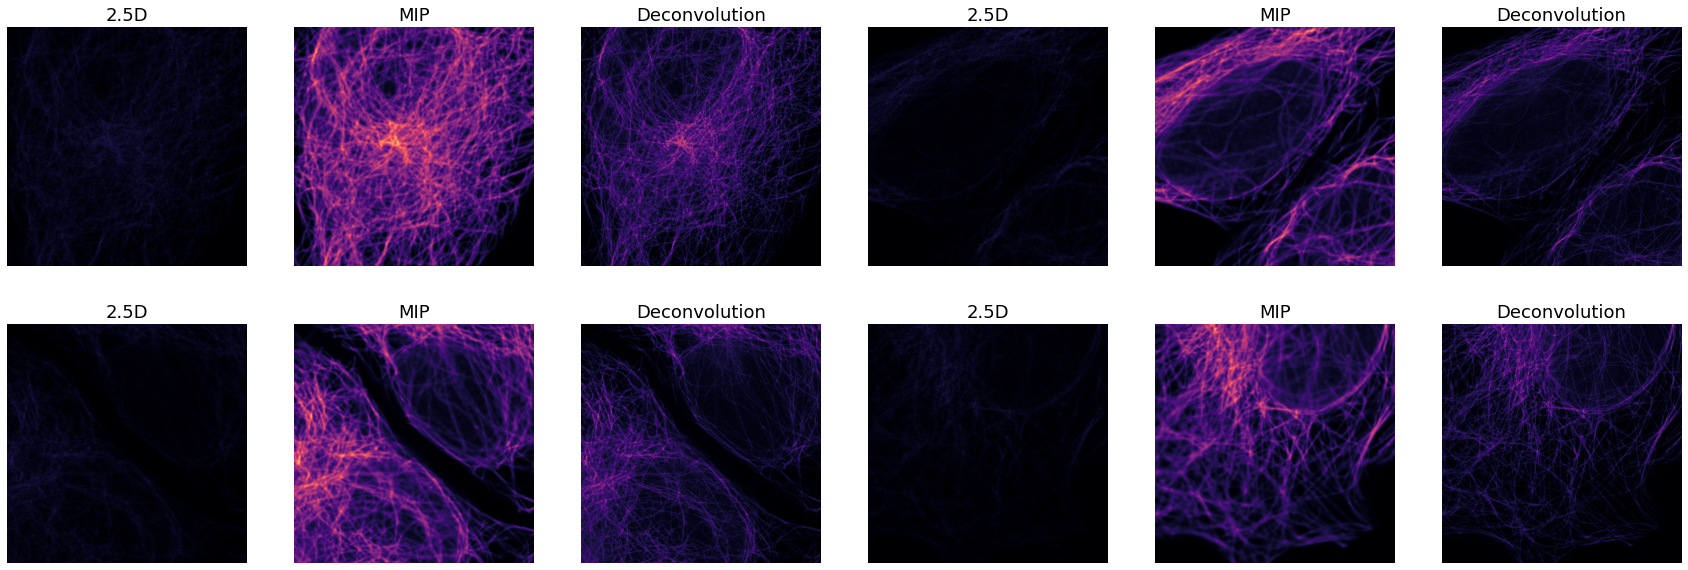

In [6]:
ix = np.random.randint(0,len(x_test),4)
fig = plt.figure(figsize=(30,10))

for i in range(4):
    fig.add_subplot(2,6, 3*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('2.5D',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,6, 3*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(w_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('MIP',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,6, 3*i+3)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_test[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Deconvolution',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [7]:
filters =[32,64,128]

num_filters = 64
r = 16
filters_cab=num_filters/r
num_RG=5
num_RCAB=5

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
generator.load_weights(model_save_directory)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction= generator(x_test[i:i+1],training=False)
    prediction1[i] = prediction['UNet']
    prediction2[i] = prediction['RCAN']
#     prediction1[i],prediction2[i]= generator(x_test[i:i+1],training=False)
    prediction1[i] = prediction1[i]/prediction1[i].max()
    prediction2[i] = prediction2[i]/prediction2[i].max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

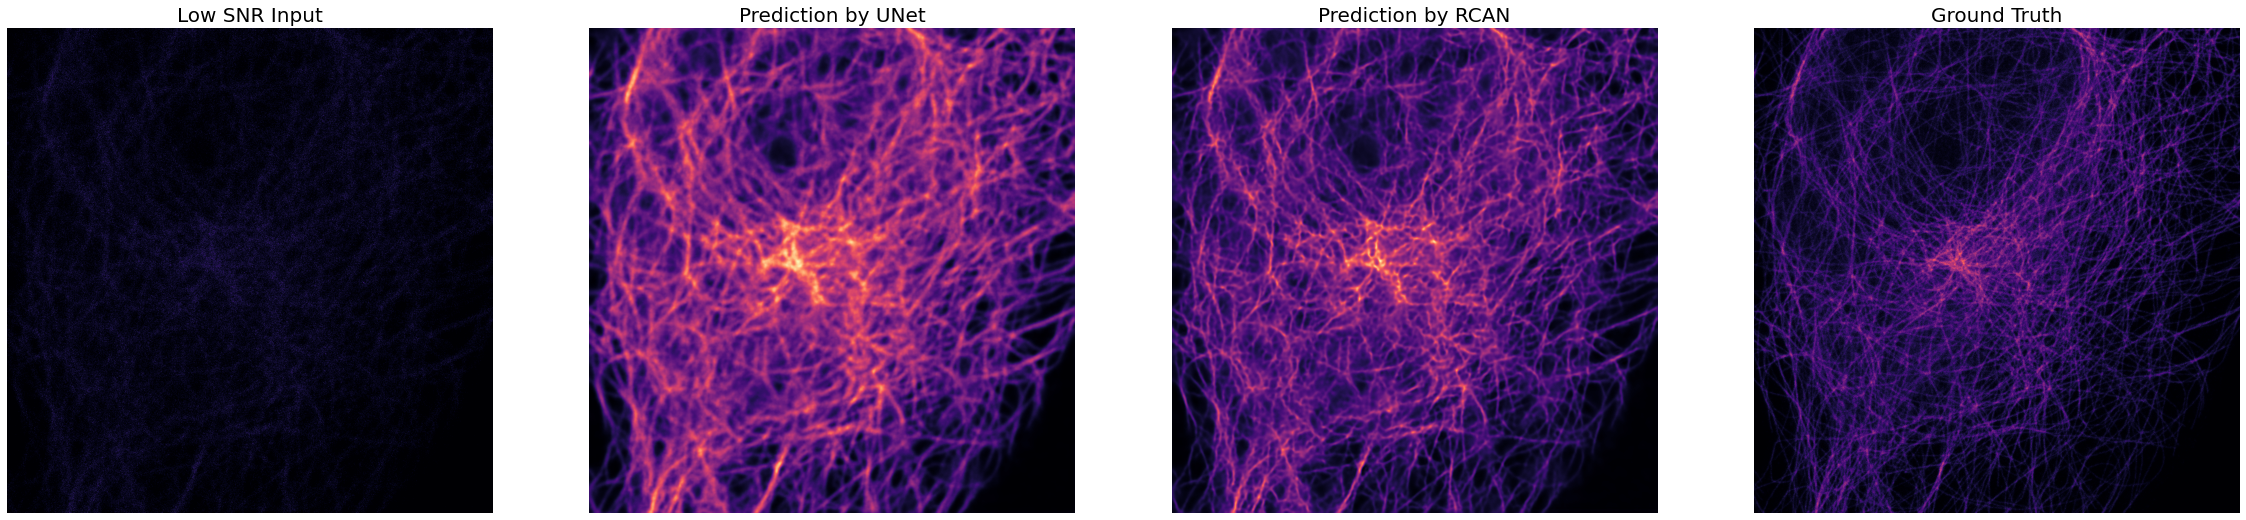

In [8]:
ix = np.random.randint(len(prediction2))
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 4, 1)
plt.imshow(x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by RCAN',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

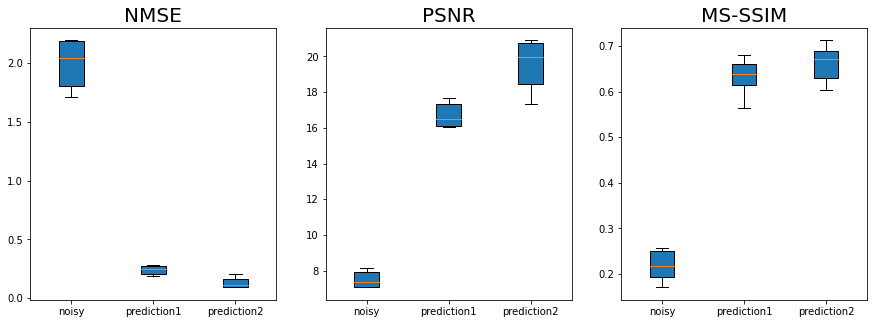

In [9]:
def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((9,len(prediction1)))

imageq_param[0::3,:] = nmse_psnr_ssim(x_test,y_test)
imageq_param[1::3,:] = nmse_psnr_ssim(prediction1,y_test)
imageq_param[2::3,:] = nmse_psnr_ssim(prediction2,y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
labels = ['noisy', 'prediction1', 'prediction2']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:],imageq_param[2,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE',fontsize=20)

bplot2 = axes[1].boxplot([imageq_param[3,:],imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR',fontsize=20)

bplot3 = axes[2].boxplot([imageq_param[6,:],imageq_param[7,:],imageq_param[8,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM',fontsize=20)

np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")

In [10]:
pred1_test = prediction1*(2**16-1)
pred2_test = prediction2*(2**16-1)
X_test = x_test*(2**16-1)
Y_test = y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
pred2_test = pred2_test.astype(np.uint16)
X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/pred1.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/pred2.tif', pred2_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/noisy.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})
imwrite(save_image_dr+'/gt.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TYX'})